Import Libraries

In [147]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from prophet import Prophet
import matplotlib.pyplot as plt
import mlflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.linear_model import LinearRegression

Step 1: Load and Explore Data

In [148]:
# Load data
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

# Display data overview
print(data.head(), "\n")
print(data.describe(), "\n")
print(data['Channel_Used'].unique(), "\n")
print(data.info(), "\n")
print(f"Missing Values:\n{data.isnull().sum()}\n")
print(f"Duplicated Rows: {data.duplicated().sum()}")

        Campaign_ID Target_Audience     Campaign_Goal Duration Channel_Used  \
226497       905855     Women 18-24    Product Launch  60 Days     Facebook   
1027         586160     Women 18-24    Product Launch  15 Days     Facebook   
232169       143298       Men 18-24    Increase Sales  60 Days      Twitter   
256361       939635       Men 35-44  Market Expansion  60 Days      Twitter   
274696       220533     Women 35-44    Product Launch  60 Days     Facebook   

        Conversion_Rate Acquisition_Cost   ROI     Location Language  Clicks  \
226497             0.06        $11455.90  3.65       Austin  English   30322   
1027               0.12          $500.00  4.03     New York  English     635   
232169             0.05        $11733.78  3.89  Los Angeles  Spanish   31069   
256361             0.13        $12951.03  1.71     New York  Spanish   34254   
274696             0.08        $14000.11  7.72        Miami   French   36668   

        Impressions  Engagement_Score Custom

Step 2: Preprocess Data for Prophet

In [149]:
# Filter data for Instagram channel and aggregate by date
channel_data = data[data['Channel_Used'] == 'Instagram']
time_series_data = channel_data.groupby('Date')['Engagement_Score'].mean().reset_index()
time_series_data.rename(columns={"Date": "ds", "Engagement_Score": "y"}, inplace=True)

# Include additional regressors
regressors = channel_data.groupby('Date')[['Clicks', 'Impressions']].mean().reset_index()
regressors.rename(columns={"Date": "ds"}, inplace=True)
time_series_data = time_series_data.merge(regressors, on="ds")

Step 3: Train Prophet Model

In [150]:
# Initialize Prophet
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet_model.add_regressor('Clicks')
prophet_model.add_regressor('Impressions')

# Fit the model
prophet_model.fit(time_series_data)

17:35:10 - cmdstanpy - INFO - Chain [1] start processing
17:35:10 - cmdstanpy - INFO - Chain [1] done processing


Step 4: Forecast with Prophet

In [151]:
# Define forecast horizon (3 years = 1095 days)
forecast_horizon = 1095

# Create future dataframe
future = prophet_model.make_future_dataframe(periods=forecast_horizon)

# Calculate mean of regressors for the last available 30 days
last_30_mean = regressors.tail(30)[['Clicks', 'Impressions']].mean()

# Create future regressors with mean values repeated
future_regressors = pd.DataFrame({
    'ds': future['ds'],
    'Clicks': [last_30_mean['Clicks']] * len(future),
    'Impressions': [last_30_mean['Impressions']] * len(future)
})

# Merge future regressors with the future dataframe
future = future.merge(future_regressors, on='ds', how='left')

# Make predictions
forecast = prophet_model.predict(future)

# Prophet Model Performance Metrics
prophet_mae = mean_absolute_error(time_series_data['y'], forecast['yhat'][:len(time_series_data)])
prophet_mse = mean_squared_error(time_series_data['y'], forecast['yhat'][:len(time_series_data)])
prophet_rmse = sqrt(prophet_mse)

print(f"Prophet Model Performance:\nMAE: {prophet_mae:.4f}\nMSE: {prophet_mse:.4f}\nRMSE: {prophet_rmse:.4f}")

Prophet Model Performance:
MAE: 0.1488
MSE: 0.0342
RMSE: 0.1849


Step 5: Prepare Data for LSTM

In [152]:
# Function to create sequences
def create_sequences(data, seq_length=7):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

# Prepare LSTM input
seq_length = 7
X, y = create_sequences(time_series_data['y'].values, seq_length)

# Reshape for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

Step 6: Define LSTM

In [153]:
# Define LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20


a:\PROJECTS\Poseidon\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 20.3790 - val_loss: 11.0236
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5444 - val_loss: 0.5587
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5165 - val_loss: 0.8678
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5599 - val_loss: 0.6083
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2818 - val_loss: 0.2657
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0716 - val_loss: 0.1196
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9234 - val_loss: 0.0990
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0004 - val_loss: 0.1350
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1006 - val_loss: 0.0461
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9560 - val_loss: 0.0621
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7931 - val_loss: 0.0967
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8230 - val_loss: 0.0503
Epoch 13/20
9/9 ━━━━

Step 7: Predict with LSTM and evaluate performance

In [154]:
# Make predictions
lstm_predictions = lstm_model.predict(X).flatten()

# LSTM Model Performance Metrics
lstm_mae = mean_absolute_error(y, lstm_predictions)
lstm_mse = mean_squared_error(y, lstm_predictions)
lstm_rmse = sqrt(lstm_mse)

print(f"LSTM Model Performance:\nMAE: {lstm_mae:.4f}\nMSE: {lstm_mse:.4f}\nRMSE: {lstm_rmse:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
LSTM Model Performance:
MAE: 0.2244
MSE: 0.0759
RMSE: 0.2755


Step 8: Ensemble Learning (Meta-Model)

In [155]:
# Align data for Meta-Model
aligned_time_series = time_series_data['y'][seq_length:]
aligned_prophet_forecast = forecast['yhat'][seq_length:len(time_series_data)]
aligned_lstm_predictions = lstm_predictions[:len(aligned_time_series)]

# Prepare input for meta-model
X_meta = pd.DataFrame({'prophet': aligned_prophet_forecast.values, 'lstm': aligned_lstm_predictions})

# Train Meta-Model (Linear Regression)
meta_model = LinearRegression()
meta_model.fit(X_meta, aligned_time_series)

# Make predictions with meta-model
meta_predictions = meta_model.predict(X_meta)

# Meta-Model Performance Metrics
meta_mae = mean_absolute_error(aligned_time_series, meta_predictions)
meta_mse = mean_squared_error(aligned_time_series, meta_predictions)
meta_rmse = sqrt(meta_mse)

print(f"Meta-Model Performance:\nMAE: {meta_mae:.4f}\nMSE: {meta_mse:.4f}\nRMSE: {meta_rmse:.4f}")

Meta-Model Performance:
MAE: 0.1475
MSE: 0.0335
RMSE: 0.1829


Step 9: Visualise Results

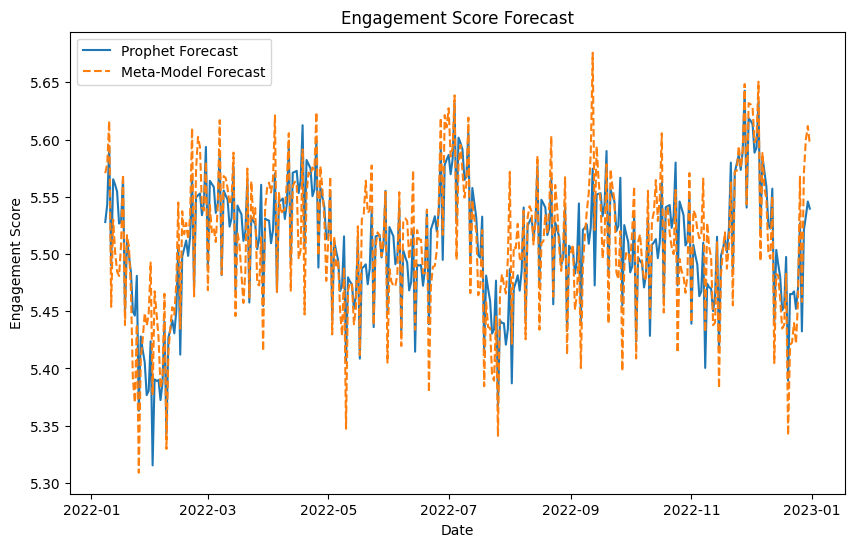

In [156]:
# Adjust the length of forecast['ds'] to match the length of aligned_meta_predictions
forecast_ds_trimmed = forecast['ds'][seq_length:len(meta_predictions) + seq_length]

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(forecast_ds_trimmed, forecast['yhat'][seq_length:len(meta_predictions) + seq_length], label="Prophet Forecast")
plt.plot(forecast_ds_trimmed, meta_predictions, label="Meta-Model Forecast", linestyle='--')
plt.legend()
plt.title("Engagement Score Forecast")
plt.xlabel("Date")
plt.ylabel("Engagement Score")
plt.show()

Step 10: Extract and Save Predictions

In [157]:
optimal_times = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30).sort_values('yhat', ascending=False)
print("Optimal Posting Times (Top 5):\n", optimal_times.head(5))

# Set up MLflow tracking
mlflow.set_tracking_uri("file:" + os.path.join(os.getcwd(), "mlruns"))
experiment_name = "prophet_lstm_meta_model"
try:
    experiment_id = mlflow.create_experiment(experiment_name)
except Exception:
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
mlflow.set_experiment(experiment_name)

# Save predictions with MLflow
mlflow.start_run()
mlflow.log_param("model", "Prophet-LSTM Meta-Model")
mlflow.log_metric("prophet_mae", prophet_mae)
mlflow.log_metric("prophet_rmse", prophet_rmse)
mlflow.log_metric("lstm_mae", lstm_mae)
mlflow.log_metric("lstm_rmse", lstm_rmse)
mlflow.log_metric("meta_mae", meta_mae)
mlflow.log_metric("meta_rmse", meta_rmse)
mlflow.log_metric("mean_forecast", optimal_times['yhat'].mean())
mlflow.end_run()

Optimal Posting Times (Top 5):
              ds      yhat  yhat_lower  yhat_upper
1430 2025-12-01  5.999348    5.760159    6.239583
1432 2025-12-03  5.963372    5.724681    6.203530
1433 2025-12-04  5.955538    5.710559    6.182554
1437 2025-12-08  5.952257    5.712575    6.162649
1434 2025-12-05  5.946648    5.713097    6.179129
